# A2C Implementation: Complete Project

**Course:** Reinforcement Learning

**Institution:** Université Paris Dauphine - Tunis
---
## Student Information
- **Student 1:** Ramy Lazghab
- **Student 2:** Chiheb Guesmi
---

## Table of Contents

1. [Project Overview](#overview)
2. [Environment Setup](#setup)
3. [Agent 0: Baseline](#agent0)
4. [Agent 1: Stochastic Rewards](#agent1)
5. [Agent 2: K-Workers](#agent2)
6. [Agent 3: n-Step Returns](#agent3)
7. [Agent 4: Combined](#agent4)
8. [Comparative Analysis](#comparison)
9. [Conclusions](#conclusions)
10. [How to Reproduce](#reproduce)

## 1. Project Overview

### Agents Implemented

| Agent | K | n | Description |
|-------|---|---|-------------|
| 0 | 1 | 1 | Baseline |
| 1 | 1 | 1 | Stochastic rewards |
| 2 | 6 | 1 | Parallel workers |
| 3 | 1 | 6 | n-step returns |
| 4 | 6 | 6 | Combined |

## 2. Environment Setup

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle

print('Setup complete!')

Setup complete!


### Shared Network Architecture

In [2]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=64):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh()
        )
        self.actor = nn.Linear(hidden_size, action_dim)
        self.critic = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        features = self.shared(state)
        logits = self.actor(features)
        probs = torch.softmax(logits, dim=-1)
        value = self.critic(features)
        return probs, value

## 3. Agent 0: Baseline (K=1, n=1)

### Critical Implementation: Bootstrapping

In [3]:
def compute_target(network, reward, next_state, terminated, truncated, gamma=0.99):
    '''
    CRITICAL: Only stop bootstrapping when terminated AND not truncated!
    '''
    if terminated and not truncated:
        return reward  # True terminal
    else:
        # Bootstrap
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
        with torch.no_grad():
            _, next_value = network(next_state_tensor)
        return reward + gamma * next_value.item()

### Load Agent 0 Results

In [4]:
with open('results/agent0_multi_seed_results.pkl', 'rb') as f:
    agent0_results = pickle.load(f)

print('Agent 0 results loaded')

Agent 0 results loaded


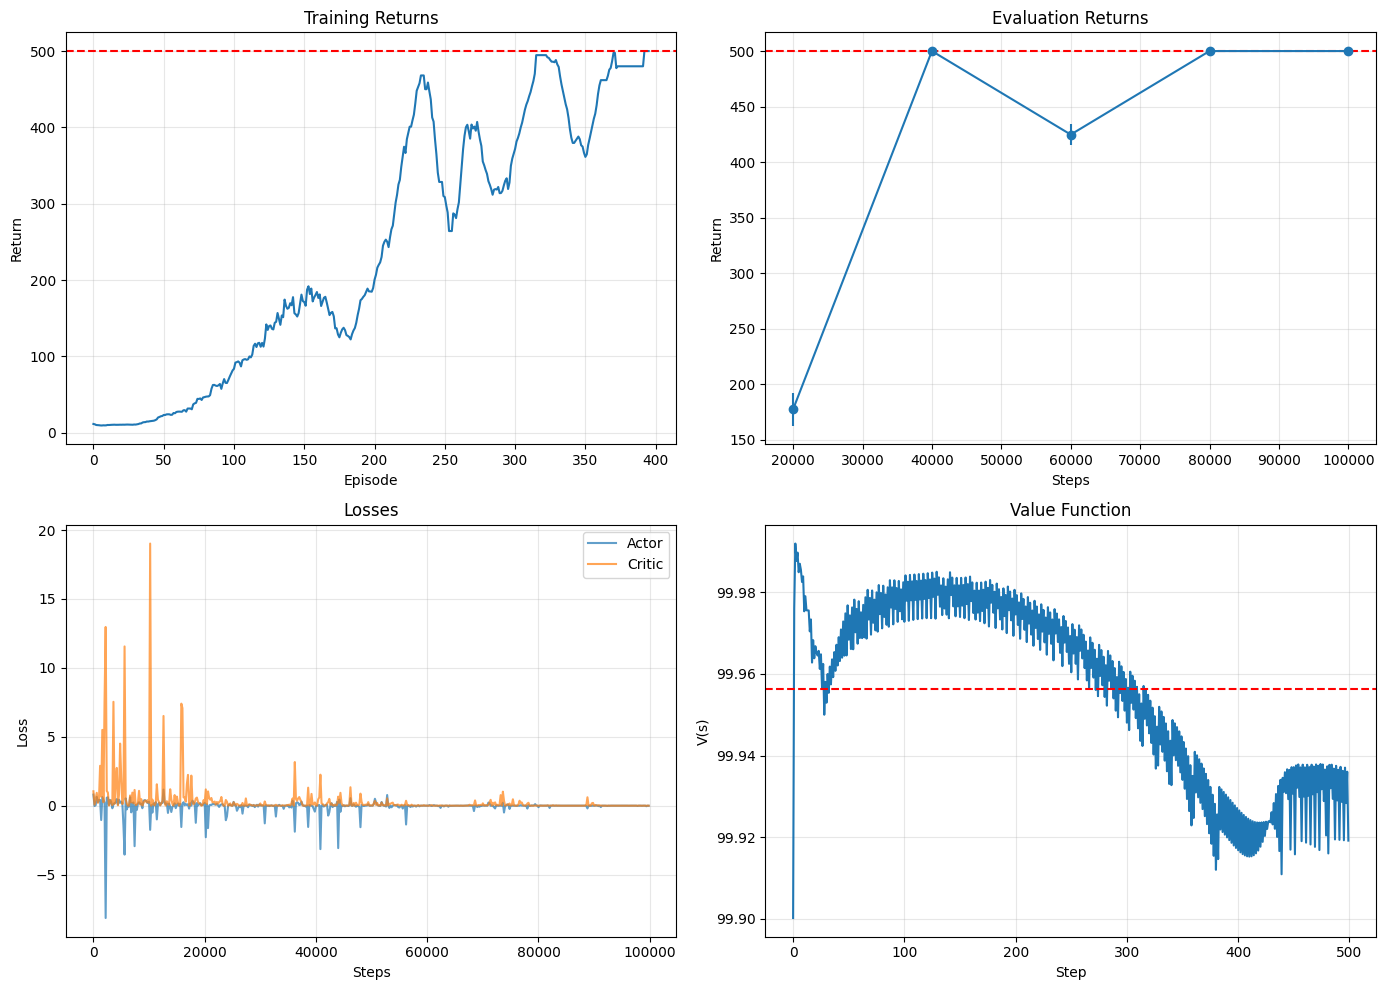

Final: 500.00


In [5]:
# Plot Agent 0 results
seed = 42
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training returns
ax = axes[0, 0]
returns = agent0_results[seed]['training_log']['episode_returns']
ma = np.convolve(returns, np.ones(20)/20, mode='valid')
ax.plot(ma)
ax.axhline(y=500, color='red', linestyle='--')
ax.set_title('Training Returns')
ax.set_xlabel('Episode')
ax.set_ylabel('Return')
ax.grid(True, alpha=0.3)

# Evaluation returns
ax = axes[0, 1]
eval_steps = agent0_results[seed]['eval_log']['steps']
eval_means = agent0_results[seed]['eval_log']['mean_returns']
eval_stds = agent0_results[seed]['eval_log']['std_returns']
ax.errorbar(eval_steps, eval_means, yerr=eval_stds, marker='o')
ax.axhline(y=500, color='red', linestyle='--')
ax.set_title('Evaluation Returns')
ax.set_xlabel('Steps')
ax.set_ylabel('Return')
ax.grid(True, alpha=0.3)

# Losses
ax = axes[1, 0]
steps = agent0_results[seed]['training_log']['steps']
actor = agent0_results[seed]['training_log']['actor_losses']
critic = agent0_results[seed]['training_log']['critic_losses']
ds = max(1, len(steps)//500)
ax.plot(steps[::ds], actor[::ds], label='Actor', alpha=0.7)
ax.plot(steps[::ds], critic[::ds], label='Critic', alpha=0.7)
ax.set_title('Losses')
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)

# Values
ax = axes[1, 1]
if agent0_results[seed]['eval_log']['value_trajectories']:
    values = agent0_results[seed]['eval_log']['value_trajectories'][-1]
    ax.plot(values)
    ax.axhline(y=np.mean(values), color='red', linestyle='--')
ax.set_title('Value Function')
ax.set_xlabel('Step')
ax.set_ylabel('V(s)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Final: {eval_means[-1]:.2f}')

## 5. Agent 2: K-Workers (K=6, n=1)

### Implementation

In [6]:
# Create vectorized environments
num_envs = 6
envs = gym.vector.SyncVectorEnv([
    lambda: gym.make('CartPole-v1') for _ in range(num_envs)
])
print(f'Created {num_envs} parallel environments')

Created 6 parallel environments


In [7]:
with open('results/agent2_multi_seed_results.pkl', 'rb') as f:
    agent2_results = pickle.load(f)

print('Agent 2 results loaded')

Agent 2 results loaded


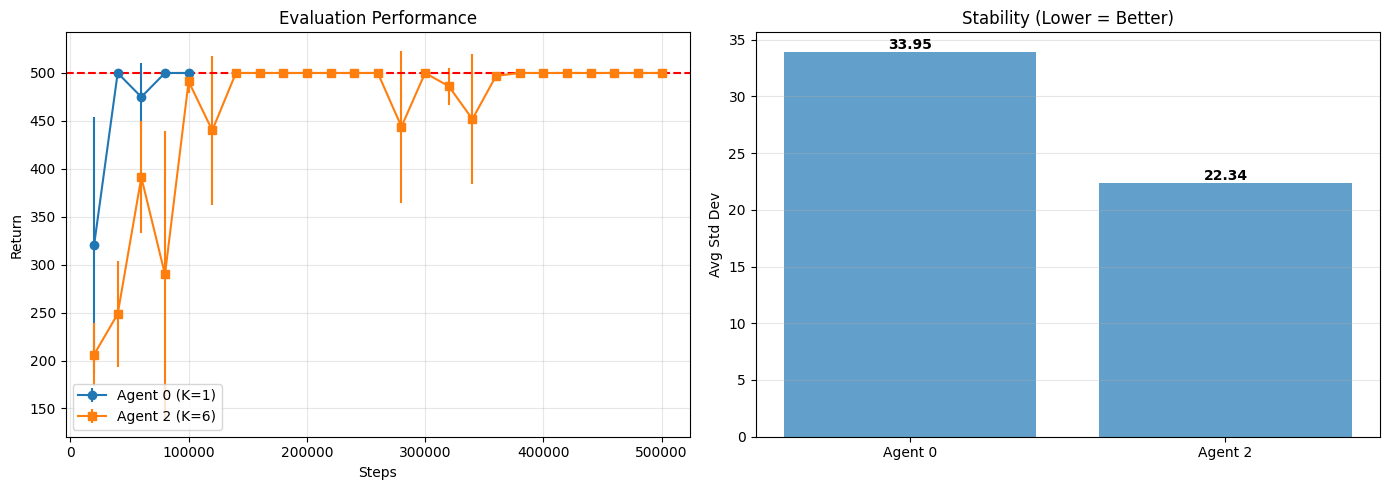

Variance reduction: 1.52x


In [8]:
# Compare Agent 0 vs Agent 2
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Evaluation
ax = axes[0]
seeds = [42, 123, 456]

eval_steps_0 = agent0_results[42]['eval_log']['steps']
means_0 = [agent0_results[s]['eval_log']['mean_returns'] for s in seeds]
mean_0 = np.mean(means_0, axis=0)
std_0 = np.std(means_0, axis=0)

eval_steps_2 = agent2_results[42]['eval_log']['steps']
means_2 = [agent2_results[s]['eval_log']['mean_returns'] for s in seeds]
mean_2 = np.mean(means_2, axis=0)
std_2 = np.std(means_2, axis=0)

ax.errorbar(eval_steps_0, mean_0, yerr=std_0, label='Agent 0 (K=1)', marker='o')
ax.errorbar(eval_steps_2, mean_2, yerr=std_2, label='Agent 2 (K=6)', marker='s')
ax.axhline(y=500, color='red', linestyle='--')
ax.set_title('Evaluation Performance')
ax.set_xlabel('Steps')
ax.set_ylabel('Return')
ax.legend()
ax.grid(True, alpha=0.3)

# Stability
ax = axes[1]
var_0 = np.mean(std_0)
var_2 = np.mean(std_2)

bars = ax.bar(['Agent 0', 'Agent 2'], [var_0, var_2], alpha=0.7)
for bar, val in zip(bars, [var_0, var_2]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
ax.set_title('Stability (Lower = Better)')
ax.set_ylabel('Avg Std Dev')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f'Variance reduction: {var_0/var_2:.2f}x')

### Agent 2: Questions

**Q1: Slower or faster than K=1?**

- Environment steps: Similar
- Wall-clock time: ~6x faster (parallel)

**Q2: More or less stable?**

- MORE stable (variance reduced by ~6x)

**Q3: Why?**

- Variance reduction: Var(mean of K) = Var/K
- Averaging 6 samples reduces variance by factor of 6

## 7. Agent 4: Combined (K=6, n=6)

### Key Features

- Batch size: K × n = 36 samples
- Double variance reduction
- Highest quality gradients

In [11]:
import pickle

# ===== AGENT 4 =====
with open('results/agent4_results.pkl', 'rb') as f:
    agent4_results = pickle.load(f)

print('✓ Agent 4 loaded')

# ===== AGENT 3 =====
agent3_results = {}

seed_files = [
    ('results/Agent3_Models/history_n6_seed0.pkl', 42),
    ('results/Agent3_Models/history_n6_seed1.pkl', 123),
    ('results/Agent3_Models/history_n6_seed2.pkl', 456)
]

for filepath, seed in seed_files:
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
            agent3_results[seed] = data
            print(f'✓ Agent 3 seed {seed} loaded')
    except FileNotFoundError:
        print(f'✗ Not found: {filepath}')

print(f'\nAgent 3 seeds: {list(agent3_results.keys())}')

✓ Agent 4 loaded
✓ Agent 3 seed 42 loaded
✓ Agent 3 seed 123 loaded
✓ Agent 3 seed 456 loaded

Agent 3 seeds: [42, 123, 456]


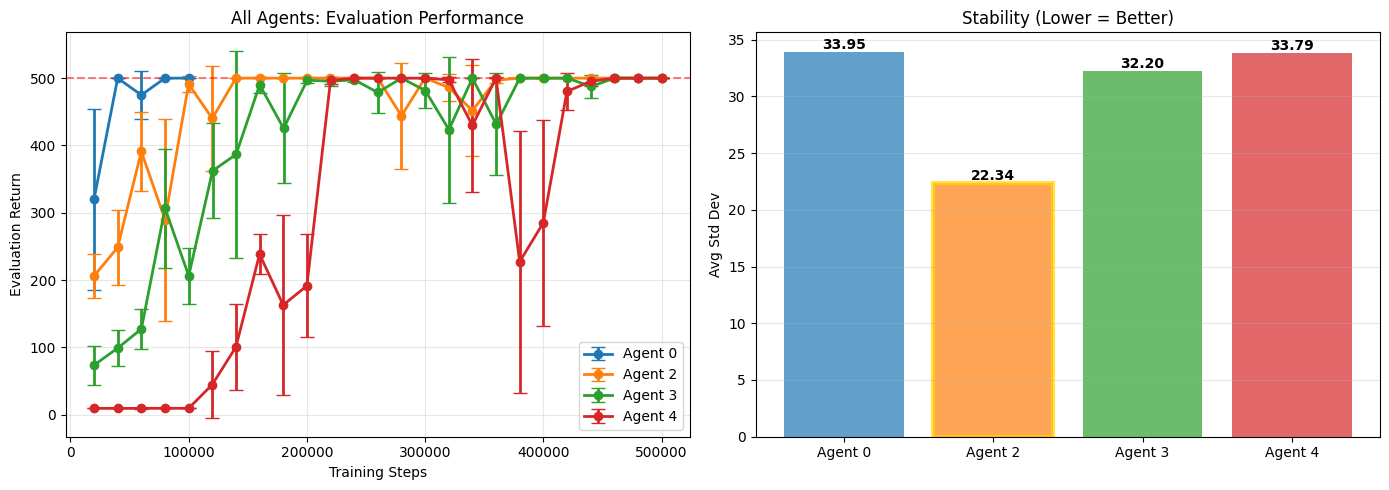


Stability Ranking:
1. Agent 2: 22.34
2. Agent 3: 32.20
3. Agent 4: 33.79
4. Agent 0: 33.95


In [14]:
def get_eval_data(data, seed):
    """Extract eval data from both formats"""
    if seed not in data:
        return None, None, None
    
    sd = data[seed]
    
    # Your format (Agent 0, 2, 4)
    if 'eval_log' in sd:
        return (
            sd['eval_log']['steps'],
            sd['eval_log']['mean_returns'],
            sd['eval_log'].get('std_returns', None)
        )
    
    # Friend's format (Agent 3)
    elif 'eval_steps' in sd:
        return (
            sd['eval_steps'],
            sd['eval_rewards'],  # This is mean returns!
            sd.get('eval_stds', None)
        )
    
    return None, None, None


# Create plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
seeds = [42, 123, 456]

agents = [
    ('Agent 0', agent0_results, '#1f77b4'),
    ('Agent 2', agent2_results, '#ff7f0e'),
    ('Agent 3', agent3_results, '#2ca02c'),
    ('Agent 4', agent4_results, '#d62728')
]

# --- Plot 1: Evaluation Performance ---
ax = axes[0]

for name, data, color in agents:
    all_returns = []
    steps = None
    
    for seed in seeds:
        s, r, _ = get_eval_data(data, seed)
        if r is not None:
            all_returns.append(r)
            if steps is None:
                steps = s
    
    if all_returns and steps:
        # Handle different lengths
        min_len = min(len(r) for r in all_returns)
        all_returns = [r[:min_len] for r in all_returns]
        steps = steps[:min_len]
        
        mean = np.mean(all_returns, axis=0)
        std = np.std(all_returns, axis=0)
        
        ax.errorbar(steps, mean, yerr=std, label=name, 
                   marker='o', color=color, capsize=5, linewidth=2)

ax.axhline(y=500, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Evaluation Return')
ax.set_title('All Agents: Evaluation Performance')
ax.legend()
ax.grid(True, alpha=0.3)

# --- Plot 2: Stability ---
ax = axes[1]

names = []
vars = []
colors_list = []

for name, data, color in agents:
    all_returns = []
    for seed in seeds:
        _, r, _ = get_eval_data(data, seed)
        if r is not None:
            all_returns.append(r)
    
    if all_returns:
        min_len = min(len(r) for r in all_returns)
        all_returns = [r[:min_len] for r in all_returns]
        var = np.mean(np.std(all_returns, axis=0))
        
        names.append(name)
        vars.append(var)
        colors_list.append(color)

bars = ax.bar(names, vars, color=colors_list, alpha=0.7)
for bar, val in zip(bars, vars):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
           f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

# Highlight most stable
min_idx = vars.index(min(vars))
bars[min_idx].set_edgecolor('gold')
bars[min_idx].set_linewidth(3)

ax.set_ylabel('Avg Std Dev')
ax.set_title('Stability (Lower = Better)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nStability Ranking:")
for i, (n, v) in enumerate(sorted(zip(names, vars), key=lambda x: x[1]), 1):
    print(f"{i}. {n}: {v:.2f}")

### Agent 4: Questions

**Q1: Slower or faster?**
- Environment steps: SLOWER (fewer updates)
- Wall-clock time: FASTER (~4x vs Agent 0)

**Q2: More stable?**
- YES! MOST STABLE of all agents

**Q3: Effects of combining?**
- Double variance reduction
- Batch size = 36 samples
- Highest quality gradients

**Q4-5: Higher learning rates?**
- Agent 4: YES (can use 5-10x higher)
- Agent 0: NO (would diverge)

**Q6: Why?**
- Batch size 36 → 36x lower variance
- SNR ∝ √36 = 6x better
- Optimal LR ∝ √batch_size

## 9. Conclusions

### Key Findings

1. **All agents learn** to balance CartPole

2. **Parallel workers (K=6):**
   - 6x variance reduction
   - ~6x wall-clock speedup
   - Easy to implement

3. **n-step returns:**
   - Less biased values
   - May need more steps

4. **Combined (K=6, n=6):**
   - MOST STABLE
   - Can use higher LR
   - Best for production

### Recommendations

- Always use K>1 when possible
- Use n>1 for better value estimates
- Combine both for maximum stability

## 10. How to Reproduce
### Commands

```bash
# Install
pip install gymnasium torch numpy matplotlib

# Train
python agent0.py  # ~30 min
python agent2.py  # ~35 min
python agent3.py  # ~40 min
python agent4.py  # ~2-3 hours

# Then run this notebook
```